# Z Rotations via Hamming Weight Phasing

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `HammingWeightPhasing`
Applies $Z^{\text{exponent}}$ to every qubit of an input register of size `bitsize`.

The goal of Hamming Weight Phasing is to reduce the number of rotations needed to
apply a single qubit rotation $Z^{\texttt{exponent}}$
to every qubit of an input register `x` of size `bitsize` from `bitsize` to $O(\log (\texttt{bitsize}))$.
Naively this would take exactly `bitsize` rotations to be synthesized. The number of rotations synthesized is
reduced by taking advantage of the insight that the resulting phase that is applied to
an input state only depends on the Hamming weight of the state. Since each `1` that is present in the input register
accumulates a phase of $(-1)^{\texttt{exponenet}}$, the total accumulated
phase of an input basis state is $(-1)^{\text{exponent} * HW(x)}$, where
$HW(x)$ is the Hamming weight of $x$. The overall procedure is done in 3 steps:

1. Compute the input register Hamming weight coherently using (at-most) $\texttt{bitsize}-1$ ancilla
    and Toffolis, storing the result in a newly allocated output
    register of size $\log_2(\texttt{bitsize})$. $HW|x\rangle \mapsto |x\rangle |HW(x)\rangle$.
    See `HammingWeightCompute` for implementation details of this step.
2. Apply $Z^{2^{k}\text{exponent}}$ to the k'th qubit of newly allocated Hamming weight
     register.
3. Uncompute the Hamming weight register and ancillas allocated in Step-1 with 0 Toffoli
    cost.

Since the size of the Hamming weight register is $\log_2(\texttt{bitsize})$, as the maximum
Hamming weight is $\texttt{bitsize}$ and we only need $\log_2$ bits to store that as an integer, we
have reduced the number of costly rotations to be synthesized from $\texttt{bitsize}$
to $\log_2(\texttt{bitsize})$. This procedure uses $\texttt{bitsize} - HW(\texttt{bitsize})$
Toffoli's and $\texttt{bitsize} - HW(\texttt{bitsize}) + \log_2(\texttt{bitsize})$
ancilla qubits to achieve this reduction in rotations.

#### Parameters
 - `bitsize`: Size of input register to apply `Z ** exponent` to.
 - `exponent`: The exponent of `Z ** exponent` to be applied to each qubit in the input register.
 - `eps`: Accuracy of synthesizing the Z rotations. 

#### Registers
 - `x`: A `THRU` register of `bitsize` qubits. 

#### References
 - [Halving the cost of quantum addition](https://arxiv.org/abs/1709.06648). , Page-4


In [2]:
from qualtran.bloqs.rotations import HammingWeightPhasing

### Example Instances

In [3]:
hamming_weight_phasing = HammingWeightPhasing(4, np.pi / 2.0)
# Applying this unitary to |1111> should be the identity, and |0101> will flip the sign.

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([hamming_weight_phasing],
           ['`hamming_weight_phasing`'])

### Call Graph

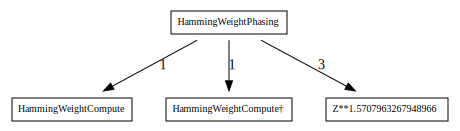

#### Counts totals:
 - `HammingWeightCompute`: 1
 - `HammingWeightCompute†`: 1
 - `Z**1.5707963267948966`: 3

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
hamming_weight_phasing_g, hamming_weight_phasing_sigma = hamming_weight_phasing.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(hamming_weight_phasing_g)
show_counts_sigma(hamming_weight_phasing_sigma)

## `HammingWeightPhasingViaPhaseGradient`
Applies $Z^{\text{exponent}}$ to every qubit of an input register of size `bitsize`.

See docstring of `HammingWeightPhasing` for more details about how hamming weight phasing works.

In this variant of Hamming Weight Phasing, instead of directly synthesizing $O(\log_2 (\texttt{bitsize}))$
rotations on the Hamming weight register we synthesize the rotations via an addition into the
phase gradient register. See reference [1] for more details on this technique.

Note: For most reasonable values of `bitsize` and `eps`, the naive `HammingWeightPhasing` would
have better constant factors than `HammingWeightPhasingViaPhaseGradient`. This is because, in
general, the primary advantage of using phase gradient is to reduce the complexity from
$O(n * \log(1/ \texttt{eps} ))$ to $O(\log^2(1/ \texttt{eps} ))$ (the phase gradient register is of size
$O(\log(1/\texttt{eps}))$ and a scaled addition into the target takes $(b_{grad} - 2)(\log(1/\texttt{eps}) + 2)$).
Therefore, to apply $n$ individual rotations on a target register of size $n$, the complexity is
independent of $n$ and is essentially a constant (scales only with $log(1/\texttt{eps})$).
However, for the actual constant values to be better, the value of $n$ needs to be
$> \log(1/\texttt{eps})$. In the case of hamming weight phasing, $n$ corresponds to the hamming weight
register which itself is $\log(\texttt{bitsize})$. Thus, as `eps` becomes smaller, the required
value of $\texttt{bitsize}$, for the phase gradient version to become more performant, becomes
larger.

#### Parameters
 - `bitsize`: Size of input register to apply `Z ** exponent` to.
 - `exponent`: The exponent of `Z ** exponent` to be applied to each qubit in the input register.
 - `eps`: Accuracy of synthesizing the Z rotations. 

#### Registers
 - `x`: Input THRU register of size `bitsize`, to apply `Z**exponent` to.
 - `phase_grad`: Phase gradient THRU register of size `O(log2(1/eps))`, to be used to apply the phasing via addition. 

#### References
 - [Compilation of Fault-Tolerant Quantum Heuristics for Combinatorial Optimization](https://arxiv.org/abs/2007.07391). Appendix A: Addition for controlled rotations


In [6]:
from qualtran.bloqs.rotations import HammingWeightPhasingViaPhaseGradient

### Example Instances

In [7]:
hamming_weight_phasing_via_phase_gradient = HammingWeightPhasingViaPhaseGradient(4, np.pi / 2.0)
# Applying this unitary to |1111> should be the identity, and |0101> will flip the sign.

#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([hamming_weight_phasing_via_phase_gradient],
           ['`hamming_weight_phasing_via_phase_gradient`'])

### Call Graph

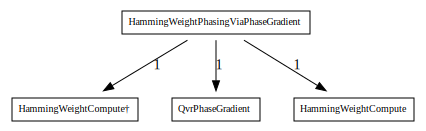

#### Counts totals:
 - `HammingWeightCompute`: 1
 - `HammingWeightCompute†`: 1
 - `QvrPhaseGradient`: 1

In [9]:
from qualtran.resource_counting.generalizers import ignore_split_join
hamming_weight_phasing_via_phase_gradient_g, hamming_weight_phasing_via_phase_gradient_sigma = hamming_weight_phasing_via_phase_gradient.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(hamming_weight_phasing_via_phase_gradient_g)
show_counts_sigma(hamming_weight_phasing_via_phase_gradient_sigma)